In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mst
from cycler import cycler
from scipy.signal import savgol_filter
from datetime import datetime
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import fmin, minimize
import glob
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable



"""Funktionen"""
def load (initpath,datei,skip,separation):
    
    initpath= initpath +"/" + datei
    temp_df = np.array(pd.read_csv(initpath, comment='~', skiprows=skip, sep=separation,
                           encoding='latin1', header=None, on_bad_lines='skip',
                           decimal='.'))
    return temp_df
    

def filtplot(array,line1,line2,plot,col):
    temp=array[array[:,1]>=line1]
    temp=temp[temp[:,1]<=line2]
    if plot: plt.plot(temp[:,0]-temp[0,0],temp[:,col])
    
    return temp


def ocv(array,line):
    temp=[]
    for i in range(len(array)):
        if array[i-1,1]==line and (array[i,1]==line+1 or array[i,1]==line-1):
            temp.append(array[i-1,:])
            
    return np.array(temp)

def dva(dataTime, dataU, dataAh):
    data = []
    for i in range(len(dataU)-1):
            dAh = dataAh[i+1] - dataAh[i]
            dU = dataU[i+1] - dataU[i]
            if dAh>=0:
                UAh = dU/dAh
            else:
                UAh = -dU/dAh
                
            if UAh!=np.inf and abs(UAh)<10000:
                data.append([dataTime[i],UAh,dataAh[i]-min(dataAh)])
    data=np.array(data)
    return data

def ica(dataTime, dataU, dataAh, step):
    data = []
    for i in range(len(dataU)-step):
            dAh = dataAh[i+step] - dataAh[i] 
            dU = dataU[i+step] - dataU[i]
            if dU!=0:
                if  dAh>=0:
                    UAh = dAh/dU
                else:
                    UAh = -dAh/dU
 
            if UAh!=np.inf:
                data.append([dataTime[i],UAh,dataU[i]])
                # data.append([dataTime[i],UAh,dataAh[i]-min(dataAh)])
    data=np.array(data)
    return data

def hppc(array,line):
    temp=array[array[:,1]==line]
    U1=temp[:,2]
    time=temp[:,0]
    # I=temp[:,3]
    
    return np.column_stack([time,U1])


def interp(ydata, xval):
    xq = np.arange(0,100,0.5)    

    x = np.array(xval, dtype=float)

    vq = interp1d(x, ydata)
    yint = vq(xq)
    return np.column_stack([xq,yint])


def consecutive(data, stepsize=3):
    return np.split(data, np.where(np.diff(data[:,0]) >= stepsize)[0]+1)

def consecutive_neu(data, stepsize=1.5):
    # Berechne Differenzen in der Zeitspalte (data[:, 0]) und in der Testspalte (data[:, 1])
    time_diff = np.diff(data[:, 0])
    test_diff = np.diff(data[:, 1])
    
    # Bedingung: Zeitdifferenz >= stepsize und Veränderung in der Testspalte
    split_indices = np.where((time_diff >= stepsize) & (test_diff != 0))[0] + 1
    
    # Array an den ermittelten Indizes aufteilen
    return np.split(data, split_indices)

def calcRi(data, datapoints):
    deltaU = data[datapoints-1,3] - data[datapoints,3]
    return abs(deltaU / data[datapoints-1,4])

def cost_func(initial_param,x,y,charge):
    J = sum(np.sqrt((y - model_func_par(x,charge,initial_param))**2))
    return J


    
def process_array(array):
    # Schritt 1: Umbruch zwischen Millisekunden- und Sekunden-Schritten finden
    diff = np.diff(array[:,0])
    break_point = np.where(diff > 0.1)[0][0] + 1  # +1, da diff eine Position weniger hat

    # Schritt 2: Werte vor dem Umbruch auf Sekundentakt zuschneiden
    pre_break_values = array[:break_point,:]
    pre_break_values = pre_break_values[::100]  # Nur jeden 100. Wert beibehalten, da 10ms -> 0.1s

    # Schritt 3: Werte nach dem Umbruch beibehalten
    post_break_values = array[break_point:,:]

    # Kombination der Arrays
    processed_array = np.concatenate((pre_break_values, post_break_values))

    return processed_array



    
def hppc_fit(array,lines,strom):
    puls_temp=[]
    temp=filtplot(array,lines[1],lines[2],plot=0,col=2)
    U1_temp=temp[:,2]
    time_temp=temp[:,0]
    splitted_temp=np.column_stack([time_temp,U1_temp])
    splitted_temp=splitted_temp.astype(float)
    splitted=consecutive(splitted_temp)
    for i in range(len(splitted)):
        splitted[i]=process_array(splitted[i])
    
    strom_temp=filtplot(array,lines[0],lines[0],plot=0,col=3)
    strom_split=consecutive(strom_temp)
    strome=[]
    for i in range(len(strom_split)):
        if strom_split[i][-1,3]<0:
            laden=0
        else:
            laden=1
        strome.append(strom_split[i][-1,3]) 
        
    R0=[]
    fit_ges=np.array([])
    plot_ges=[]
    for i in range(len(splitted)):
        if i<len(strome):
            R0= abs((splitted[i][0,1]-strom_split[i][-1,2]) / strome[i])
        x=splitted[i][1:,0] - splitted[i][0,0] #delta Zeit als x-Werte
        x = x[:]
        
        if splitted[i][0,1] > splitted[i][-1,1]:
            y = splitted[i][1:,1] - splitted[i][-1,1] #delta U als y-Werte
        else:
            y = splitted[i][1:,1] - splitted[i][0,1]
        initial_param = np.array([0.1, 10, 0.2, 100])
       
        solution = fmin(cost_func,initial_param,args=(x,y,laden))  
        
        plotVal = model_func_par(x,laden, solution)
        plot_ges.append(plotVal)
        if i<len(strome):
            R1=solution[0]/abs(strome[i])
            C1=solution[1]/R1
            R2=solution[2]/abs(strome[i])
            C2=solution[3]/R2
            fit=np.array([R0,R1,C1,R2,C2])
    
            if i==0:
                fit_ges=fit
            else:
                fit_ges=np.column_stack([fit_ges,fit])
    return plot_ges,fit_ges

def model_func(t, U1, tau1, U2, tau2, charge):
    if charge:
        return U1 * np.exp(-t / tau1) + U2 * np.exp(-t / tau2)
    else:
        return U1 * (1 - np.exp(-t / tau1)) + U2 * (1 - np.exp(-t / tau2))
    

def model_func_par(t, charge, param):
    U1, tau1, U2, tau2 = param
    if charge:
        return U1 * np.exp(-t/tau1) + U2 * np.exp(-t/tau2)
    else:
        return U1 * ( 1- np.exp(-t/tau1)) + U2 * (1 - np.exp(-t/tau2))
    
    
def fit_with_curve_fit(x, y, charge):
    # Initiale Parameterwerte
    # initial_param = [0.05, 300, 0.05, 300] # [U1, tau1, U2, tau2]
    initial_param = [0.1, 10, 0.1, 100] 

    
    # Grenzen für die Parameter
    bounds_lower = [0, 1, 0, 1]  # Untere Grenzen: U1, tau1, U2, tau2
    # bounds_upper = [0.1, 600, 0.1, 600]  # Obere Grenzen: U1, tau1, U2, tau2
    bounds_upper = [1, 50, 1, 400]  

    
    # Anonyme Funktion für die Richtung (Laden/Entladen)
    def model_to_fit(t, U1, tau1, U2, tau2):
        return model_func(t, U1, tau1, U2, tau2, charge)
    
    # Curve Fit anwenden
    popt, pcov = curve_fit(
        model_to_fit, x, y, p0=initial_param, bounds=(bounds_lower, bounds_upper)
    )
    return popt, pcov

def hppc_fit_grenzen(array, lines, strom, neu):
    puls_temp = []
    temp = filtplot(array, lines[1], lines[2], plot=0, col=2)
    print(temp)
    # U1_temp = temp[:, 2]
    # time_temp = temp[:, 0]
    # cap_temp = temp[:,4]
    # splitted_temp = np.column_stack([time_temp, U1_temp,cap_temp])
    splitted_temp = temp.astype(float)
    if neu==True:
        splitted = consecutive_neu(splitted_temp)
        for i in range(len(splitted)):
            splitted[i] = process_array(splitted[i])
    elif neu==False:
        splitted= consecutive(splitted_temp)
    else:
        print("Fehler bei der Aufteilung der Pulsdaten")
        return None, None, None, None
    
    strom_temp = filtplot(array, lines[0], lines[0], plot=0, col=3)
    strom_split = consecutive(strom_temp)
    strome = []
    for i in range(len(strom_split)):
        if strom_split[i][-1, 3] < 0:
            laden = 0
        else:
            laden = 1
        strome.append(strom_split[i][-1, 3])

    R0 = []
    U0 = []
    IR=np.array([])
    fit_ges = np.array([])
    plot_ges = []
    for i in range(len(splitted)):
        if i < len(strome):
            R0 = abs((splitted[i][0, 2] - strom_split[i][-1, 2]) / strome[i])
            U0 = abs((splitted[i][0, 2] - strom_split[i][-1, 2])) # falls U0 der IR Drop ist
            # U0 = abs((splitted[i][-1, 2] - strom_split[i][-1, 2])) # falls U0 die gesamte differenz ist

            UOCV=splitted[i][-1,2]
        x = splitted[i][1:, 0] - splitted[i][0, 0]  # delta Zeit als x-Werte
        x = x[:]
        if splitted[i][0, 2] > splitted[i][-1,2]:
            y = splitted[i][1:, 2] - splitted[i][-1,2]  # delta U als y-Werte
        else:
            y = splitted[i][1:, 2] - splitted[i][0, 2]

        # Curve Fit anwenden
        try:
            solution, covariance = fit_with_curve_fit(x, y, laden)
            plotVal = model_func(x, solution[0], solution[1], solution[2], solution[3], laden)
            plot_ges.append(plotVal)

            if i < len(strome):
                cap=np.mean(splitted[i][:,4])
                R1 = solution[0] / abs(strome[i])
                Tau1 = solution[1] 
                R2 = solution[2] / abs(strome[i])
                Tau2 = solution[3] 
                fit = np.array([cap,R0, R1, Tau1, R2, Tau2])
                mod=np.array([cap,UOCV,U0])
                if i == 0:
                    fit_ges = fit
                    IR=mod
                else:
                    fit_ges = np.column_stack([fit_ges, fit])
                    IR = np.column_stack([IR, mod])

        except RuntimeError as e:
            print(f"Curve fitting failed for pulse {i}: {e}")
            
    if laden==1:
        IR[0,:]-=IR[0,0]
        fit_ges[0,:]-=fit_ges[0,0]
        # SOC=fit_ges[0,:]/fit_ges[0,-1]
    elif laden==0:
        IR[0,:]-=IR[0,-1]
        fit_ges[0,:]-=fit_ges[0,-1]
    else:
        print("Fehler bei Laderichtungsbestimmung")
    SOC_vol=np.array([fit_ges[0,:],IR[0,:]])
    
    
    return plot_ges, fit_ges,strom_split,IR






Plot Layout

In [2]:
from cycler import cycler
"""
Plot Farbeinstellungen
"""
plt.style.use('seaborn-v0_8')

default_cycler = (cycler(color=['#cc0000', '#22a15c', '#ff8000', '#00a6b3']))
plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)
plt.rcParams["figure.figsize"] = (9,7)
plt.rcParams["legend.fontsize"] = 18
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
fontsize = 20
labelsize=20

Daten einlesen
Struktur: time line U I Ah Ah-Step T1 T2

In [3]:
initpath=r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\VglHEHP"
dateinamen = os.listdir(initpath)
# dateien= [datei for datei in dateinamen if "_CU" in datei or "Checkup" in datei]
dateien= [datei for datei in dateinamen if "46_03_" in datei]
data=[]
data_test={}
for datei in dateien:	 
    data_raw=load(initpath,datei,skip=0,separation=",")
    data_temp= np.delete(data_raw, [1, 2, 3, 4, 6, 10, 11, 12, 13, 14, 15, 16,17,18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,32], axis=1)
    data.append(data_temp)
    data_test[datei]=data_temp

initpath=r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\Age_Pouch"
dateinamen = os.listdir(initpath)
# dateien= [datei for datei in dateinamen if "_CU" in datei or "Checkup" in datei]
dateien= [datei for datei in dateinamen if "CUB21NMC6001_TA_preCheckup" in datei]
data=[]
for datei in dateien:	 
    data_raw=load(initpath,datei,skip=0,separation=" ")
    data_temp=np.delete(data_raw,[1,2,3,5,12,13],1)
    data.append(data_temp)
    data_test[datei]=data_temp


Daten anschauen


In [4]:
# test=filtplot(data_test["CUB21NMC60_03_CU_22deg.txt"],56,64,plot=1,col=2)


Kapazität bestimmen und Temperaturverläufe

In [5]:
# capacities={}
# cccv_dis={}
# temperatures={}
# cap_verlauf={}
# OCV_cap={}
# for i in data_test.keys():
#     temp=filtplot(data_test[i],9,10,plot=0,col=4)
#     cap_temp=temp[-1,4]- temp[0,4]
#     capacities[i]={}
#     cap_verlauf[i]={}
#     capacities[i]["dis"]=abs(cap_temp)
#     cap_verlauf[i]["dis"]=temp
#     print(i+" dis capacity: "+str(abs(cap_temp)))
#     OCV_cap[i]={}
#     OCV_cap[i]["dis"]=temp[temp[:,1]==9]
#     cccv_dis[i]=temp

#     temp2=filtplot(data_test[i],16,17,plot=0,col=4)
#     capacities[i]["ch"]=abs(temp2[-1,4]- temp2[0,4])
#     cap_verlauf[i]["ch"]=temp2
#     print(i+" ch capacity: "+str(capacities[i]["ch"]))
#     temperatures[i]=np.array([data_test[i][:,0],data_test[i][:,6], data_test[i][:,7]]).T
#     OCV_cap[i]["ch"]=temp2[temp2[:,1]==16]
    
# for d in ["ch","dis"]:


#     plt.figure()
#     for cell in ["4606","6001"]:
#         zähler=0
#         zelle_tests=[test for test in cap_verlauf.keys() if cell in test.lower()]
#         zelle_tests=[zelle_tests[-1]]+zelle_tests[:-1]
#         # print(zelle_tests)
        
#         for c in zelle_tests:
#             if "6001" in c:
#                 lab="60Ah"+" "+d if zähler == 0 else None
#                 colo='#cc0000'
#             elif "4606" in c:
#                 lab="46Ah"+" "+d if zähler == 0 else None
#                 colo='#22a15c'
#             else:
#                 print("Fehler bei der Zellenauswahl")
#                 break

#             anzahl=len(zelle_tests)
#             a=1-zähler/anzahl*0.8
#             plt.plot(cap_verlauf[c][d][:,0]-cap_verlauf[c][d][0,0],cap_verlauf[c][d][:,7],label=lab,alpha=a,color=colo)   
#             zähler+=1

#     plt.xlabel("Zeit (h)",fontsize=fontsize)
#     plt.ylabel("T (°C)",fontsize=fontsize)
#     plt.legend(fontsize=labelsize)
#     plt.show()
 

GITT auswerten mit 2RC Fit

In [6]:
lines_dis60=[25,26,27]
lines_dis46=[58,59,59]
lines_ch60=[36,37,38]
lines_ch46=[68,69,69]

fit_all={}
plot_all={}
hppc_data=[]
IR_all={}
l=0

for t in data_test.keys():
    data_t=data_test[t].copy()
    data_t[:,0]=data_t[:,0]*3600
    strome=[]
    if "46_" in t:
        lines=[lines_dis46,lines_ch46]
        neu=False
    elif "6001" in t:
        lines=[lines_dis60,lines_ch60]
        neu=True
    else:
        print("Fehler bei der Zellenauswahl")
        break

    for i in range(len(lines)):
        temp=filtplot(data_t,lines[i][1],lines[i][2],plot=0,col=3)
        temp=temp.astype(float)
        temp=consecutive_neu(temp) 
        # for i in range(len(temp)):
        #     temp[i]=process_array(temp[i])
        hppc_data.append(temp)
    plot_data,fit_data,IR_data=[],[],[]
    for i in range(len(lines)):
        plot_temp,fit_temp,strom,IR =hppc_fit_grenzen(data_t,lines[i],0,neu=neu)
        fit_temp=np.vstack([fit_temp])
        plot_data.append(plot_temp)
        fit_data.append(fit_temp)
        IR_data.append(IR)
    plot_all[t]=plot_data
    fit_all[t]=fit_data    
    IR_all[t]=IR_data
    print(t)

[[159065.90352866665 59 4.15498396574973 0.0 36.647128949532]
 [159065.90553366684 59 4.1547923151978 0.0 36.647128949532]
 [159066.90353499984 59 4.15862532623632 0.0 36.647128949532]
 ...
 [198799.0339933332 59 3.03172008091305 0.0 -10.5074697217899]
 [198800.03399266655 59 3.03172008091305 0.0 -10.5074697217899]
 [198801.03399333337 59 3.03191173146498 0.0 -10.5074697217899]]
[[202439.26142399988 69 3.26419220039896 0.0 -10.0324922317597]
 [202439.2634243334 69 3.2638088992951 0.0 -10.0324922317597]
 [202440.26142433332 69 3.25154326397186 0.0 -10.0324922317597]
 ...
 [242066.32924533339 69 4.1607334823075 0.0 35.7659589939545]
 [242067.32924533344 69 4.16054183175557 0.0 35.7659589939545]
 [242068.32924633325 69 4.16054183175557 0.0 35.7659589939545]]
CUB21NMC46_03_CU_25deg.txt
[[84573.14009600016 26 4.1521830858639 ... 0.0 26.1864603263928
  26.1682020802377]
 [84573.14210300017 26 4.1521830858639 ... 0.0 26.1864603263928
  26.1682020802377]
 [84573.15009599988 26 4.15237482832919

Parameter plotten

['CUB21NMC46_03_CU_25deg.txt']
['CUB21NMC6001_TA_preCheckup.txt']
6001


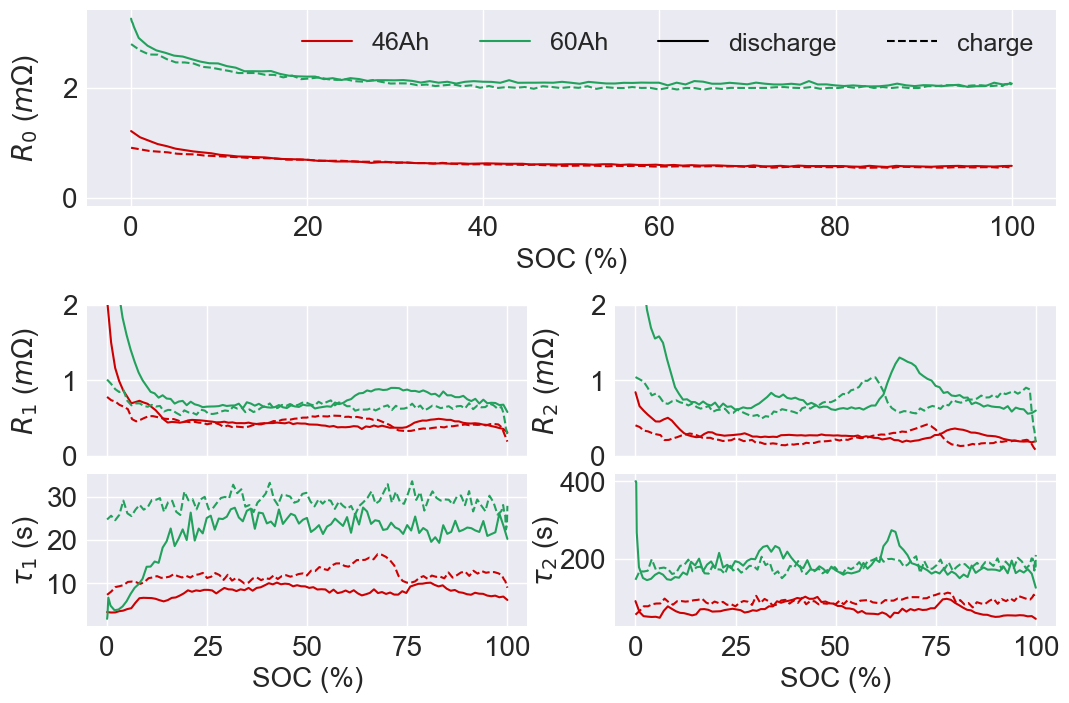

In [72]:
#--------------------------------
#über Spannung oder SOC
xAchse_t="SOC[%]"
# xAchse_t="U[V]"
#-------------------------------
fig = plt.figure(figsize=(12.5, 8))
gs = gridspec.GridSpec(3, 2, height_ratios=[1.3, 1, 1])  # 3 Zeilen, 2 Spalten
gs.update(hspace=0.35)  # Weniger Abstand vertikal
ax00 = fig.add_subplot(gs[0, :])  # obere Reihe
ax20 = fig.add_subplot(gs[2, 0])  # unten links
ax21 = fig.add_subplot(gs[2, 1])  # unten rechts
ax10 = fig.add_subplot(gs[1, 0], sharex=ax20)
ax11 = fig.add_subplot(gs[1, 1], sharex=ax21)
plt.setp(ax10.get_xticklabels(), visible=False)
plt.setp(ax11.get_xticklabels(), visible=False)


colors=['#cc0000', '#22a15c', '#ff8000', '#00a6b3']
f=0
for cell in ["46_","6001"]:
    zähler=0
    zelle_tests=[test for test in fit_all.keys() if cell in test.lower()]
    zelle_tests=[zelle_tests[-1]]+zelle_tests[:-1]
    print(zelle_tests)
   


    for c in zelle_tests:
        anzahl=len(zelle_tests)
        a=1-zähler/anzahl*0.8
        # Plotten
        if xAchse_t=="SOC[%]":
            x_t1=IR_all[c][0][0,:]/IR_all[c][0][0,0]*100
            x_t2=IR_all[c][1][0,:]/IR_all[c][1][0,-1]*100
        elif xAchse_t=="U[V]":
            x_t1=IR_all[c][0][1,:]
            x_t2=IR_all[c][1][1,:]

        # Nur beim ersten Plot Label setzen
        label_dis = "46Ah" if cell=="46_" else "60Ah"

        # Entladen (rot)
        ax00.plot(x_t1, fit_all[c][0][1, :]*1000, label=label_dis, alpha=a, color=colors[f])
        ax10.plot(x_t1, fit_all[c][0][2, :]*1000, alpha=a, color=colors[f])
        ax20.plot(x_t1, fit_all[c][0][3, :], alpha=a, color=colors[f])
        ax11.plot(x_t1, fit_all[c][0][4, :]*1000, alpha=a, color=colors[f])
        ax21.plot(x_t1, fit_all[c][0][5, :], alpha=a, color=colors[f])

        # Laden (grün)
        ax00.plot(x_t2, fit_all[c][1][1, :]*1000, alpha=a, color=colors[f],linestyle="--")
        ax10.plot(x_t2, fit_all[c][1][2, :]*1000, alpha=a, color=colors[f],linestyle="--")
        ax20.plot(x_t2, fit_all[c][1][3, :], alpha=a, color=colors[f],linestyle="--")
        ax11.plot(x_t2, fit_all[c][1][4, :]*1000, alpha=a, color=colors[f],linestyle="--")
        ax21.plot(x_t2, fit_all[c][1][5, :], alpha=a, color=colors[f],linestyle="--")
        zähler+=1
    f+=1
# Achsen Titel
ax00.plot(0,fit_all[c][0][1, 0], color='black',label="discharge") 
ax00.plot(0,fit_all[c][0][1, 0], color='black',label="charge",linestyle="--")  # Dummy Plot für die Legende
ax00.set_ylabel("$R_0$ ($m\Omega$)",labelpad=15)
ax10.set_ylabel("$R_1$ ($m\Omega$)",labelpad=15)
ax11.set_ylabel("$R_2$ ($m\Omega$)",labelpad=20)
ax20.set_ylabel(r"$\tau_1$ (s)")
ax21.set_ylabel(r"$\tau_2$ (s)")
ax21.yaxis.set_label_coords(-0.123, 0.5)    # (x, y) in Achsen-Koordinaten


# # ylim
if xAchse_t=="SOC[%]":
    ax10.set_ylim(0, 2)
    ax11.set_ylim(0, 2)

# Legende
ax00.legend(ncol=4)
ax00.set_xlabel("SOC (%)")
ax20.set_xlabel("SOC (%)")
ax21.set_xlabel("SOC (%)")
# Gesamttitel
# fig.suptitle(c, fontsize=16, fontweight='bold', y=0.98)
print(cell)
# plt.tight_layout()
pos = ax10.get_position()  # aktuelle Position holen
ax10.set_position([pos.x0, pos.y0 -0.05, pos.width, pos.height])
pos2 = ax11.get_position()  # aktuelle Position holen
ax11.set_position([pos2.x0, pos2.y0 -0.05, pos2.width, pos2.height])
plt.show()

Fits anschauen

In [8]:
# plt.plot(plot_all["CUB21NMC4606_TA_preCheckup.txt"][0][0], label="dis")
# plt.plot(hppc_data[2][0][:,0]-hppc_data[2][0][0,0],hppc_data[2][0][:,2]-hppc_data[2][0][0,2])

Temperaturverläufe während Strompulsen am Ende des Tests

In [66]:
# strompulse_data={}
# for i in data_test.keys():
#     print(i)
#     strompulse_temp=filtplot(data_test[i], 49, 50, plot=0, col=7)
#     strompulse_data[i]=strompulse_temp
#     plt.plot(strompulse_temp[:,0]-strompulse_temp[0,0],strompulse_temp[:,6],label="T1")
#     plt.plot(strompulse_temp[:,0]-strompulse_temp[0,0],strompulse_temp[:,7],label="T2")
#     plt.xlabel("Zeit [h]")
#     plt.ylabel("Temperatur [°C]")
#     plt.legend()
#     plt.show()


Gesamter Temperaturverlauf

In [10]:
# for i in temperatures.keys():
#     fig, ax1 = plt.subplots()
#     ax1.plot(data_test[i][:,0], data_test[i][:,3], label="I", color="#00a6b3",alpha=0.5)
#     ax1.set_ylabel("Strom [A]")
#     ax1.legend(loc="upper left")
#     ax1.set_xlabel("Zeit [h]")
#     ax1.set_ylim(-80,80)

#     ax2 = ax1.twinx()
#     ax2.plot(temperatures[i][:,0], temperatures[i][:,1], label="T1", color="#cc0000")
#     ax2.plot(temperatures[i][:,0], temperatures[i][:,2], label="T2", color="#22a15c")
#     ax2.set_ylabel("Temperatur [°C]")
#     ax2.legend(loc="upper center")
#     ax2.set_ylim(20,40)
#     print(i)
#     plt.show()

iOCV Auswertung mit ICA und DVA

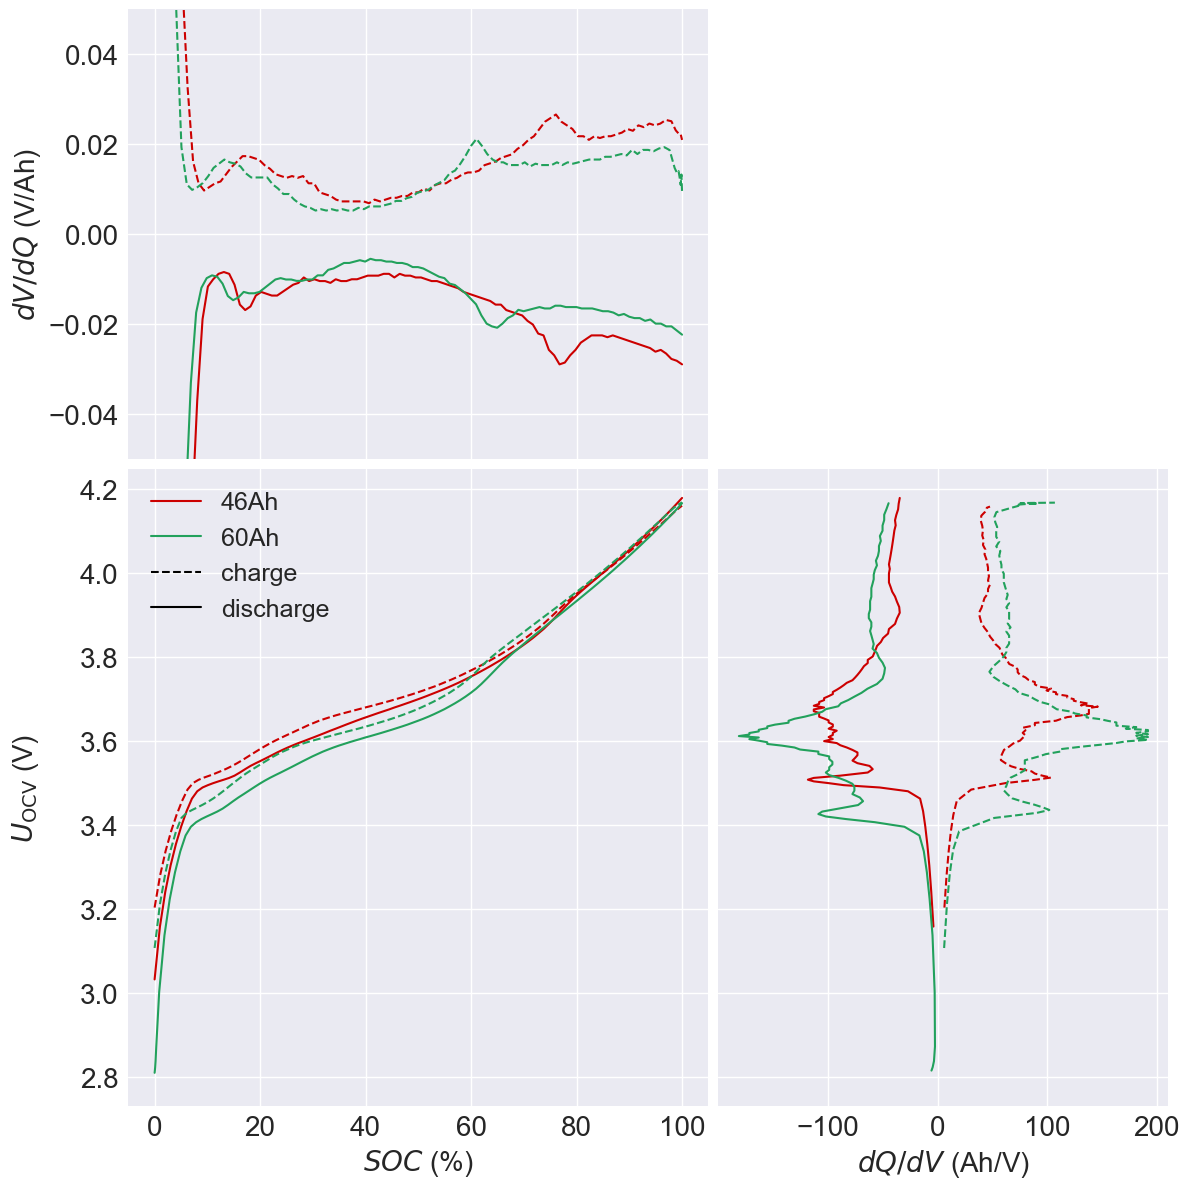

In [11]:
OCV={}
DVA={}
ICA={}
OCV_arrays={}
# lines_dis=[25,26,27]
# lines_ch=[36,37,38]
for i in data_test.keys():
    OCV[i]={}
    DVA[i]={}
    ICA[i]={}
    if "46" in i:
        lines=[[58,59],[68,69]]
    elif "60" in i:
        lines=[[26,27],[37,38]]
    else:
        print("Fehler bei der Lineauswahl")
        break
    tempdis=filtplot(data_test[i],lines[0][0],lines[0][1],plot=0,col=2)
    tempdis=ocv(tempdis,lines[0][1])
    tempdis = np.vstack((tempdis[1:], tempdis[0]))
    OCV[i]["dis"]=tempdis
    tempch=filtplot(data_test[i],lines[1][0],lines[1][1],plot=0,col=2)
    tempch=ocv(tempch,lines[1][1])
    tempch = np.vstack((tempch[1:], tempch[0]))
    OCV[i]["ch"]=tempch
    
    DVA[i]["ch"]=dva(OCV[i]["ch"][:,0],OCV[i]["ch"][:,2],OCV[i]["ch"][:,4])
    DVA[i]["dis"]=dva(OCV[i]["dis"][:,0],OCV[i]["dis"][:,2],OCV[i]["dis"][:,4])
    
    ICA[i]["ch"]=ica(OCV[i]["ch"][:,0],OCV[i]["ch"][:,2],OCV[i]["ch"][:,4],step=1)
    ICA[i]["dis"]=ica(OCV[i]["dis"][:,0],OCV[i]["dis"][:,2],OCV[i]["dis"][:,4],step=1)
    


colors = ['#cc0000', '#22a15c'] 
fig, ax_ocv = plt.subplots(figsize=(12, 12))  # Hauptplot

divider = make_axes_locatable(ax_ocv)
ax_dva = divider.append_axes("top", size=4.5, pad=0.1, sharex=ax_ocv)
ax_ica = divider.append_axes("right", size=4.5, pad=0.1, sharey=ax_ocv)

# Achsenbeschriftungen unsichtbar machen
ax_dva.xaxis.set_tick_params(labelbottom=False)
ax_ica.yaxis.set_tick_params(labelleft=False)

# Für jede Zelle
for f, cell in enumerate(["46_", "6001"]):
    zelle_tests = [test for test in OCV.keys() if cell in test.lower()]
    
    for c in zelle_tests:
        label_cell = "46Ah" if cell == "46_" else "60Ah"

        ch = OCV[c]["ch"]
        dis = OCV[c]["dis"]
        dQ_ch = ch[:, 4] - min(ch[:, 4])
        dQ_dis = dis[:, 4] - min(dis[:, 4])
        OCV_arrays[label_cell+"_dis"]=np.vstack((dQ_dis/dQ_dis[0]*100, dis[:, 2]))
        OCV_arrays[label_cell+"_ch"]=np.vstack((dQ_ch/dQ_ch[-1]*100, ch[:, 2]))

        # OCV Plot
        ax_ocv.plot(dQ_ch / dQ_ch[-1] * 100, ch[:, 2], color=colors[f], linestyle="--")
        ax_ocv.plot(dQ_dis / dQ_dis[0] * 100, dis[:, 2], color=colors[f], label=label_cell)

        # DVA Plot
        dva_ch = DVA[c]["ch"]
        dva_dis = DVA[c]["dis"]
        ax_dva.plot(dva_ch[:, 2]/dva_ch[-1,2]*100, dva_ch[:, 1], color=colors[f], linestyle="--")
        ax_dva.plot(dva_dis[:, 2]/dva_dis[0,2]*100, dva_dis[:, 1], color=colors[f])

        # ICA Plot
        ica_ch = ICA[c]["ch"]
        ica_dis = ICA[c]["dis"]
        ax_ica.plot(ica_ch[:, 1], ica_ch[:, 2], color=colors[f], linestyle="--")
        ax_ica.plot(ica_dis[:, 1], ica_dis[:, 2], color=colors[f])

# Formatierungen
fontsize=20
ax_ocv.plot(0,2.8, color='black', linestyle='--', label='charge')
ax_ocv.plot(0,2.8, color='black', label='discharge')
ax_ocv.set_ylabel('$U_\mathrm{OCV} $ (V)',fontsize=fontsize,labelpad=28)
ax_ocv.set_xlabel('$SOC$ (%)', fontsize=fontsize)

ax_ocv.grid(True)
ax_ocv.legend(loc='best')

ax_dva.set_ylabel('$dV/dQ$ (V/Ah)', fontsize=fontsize)
ax_dva.set_ylim(-0.05, 0.05)
ax_dva.grid(True)

ax_ica.set_xlabel('$dQ/dV$ (Ah/V)', fontsize=fontsize)
# ax_ica.set_xlim(-200,200)
ax_ica.grid(True)
plt.tight_layout()
plt.show()

OCV Arrays speichern

In [12]:
# for i in OCV_arrays.keys():
#     np.savetxt(r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\OCV_arrays/"+f"OCV_{i}.csv", OCV_arrays[i].T, delimiter=",", header="SOC[%],U[V]", comments='')